Loading Model and Data

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
# load model and data from huggingface

import os
import sys
import numpy as np
import torch
from datasets import load_dataset, concatenate_datasets, DatasetDict
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor

# load pretrained model (here wav2vec2)
# you can find many other models on huggingface.co
processor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")

# load data
# you can find many other datasets on huggingface.co
savee_dataset = load_dataset("AbstractTTS/SAVEE")
ravdess_dataset = load_dataset("AbstractTTS/RAVDESS")

savee_data = savee_dataset['train']
ravdess_data = ravdess_dataset['train']

emotion_mapping = {
    "neutral": "neutral",
    "fear": "fear",
    "disgust": "disgust",
    "happiness": "happiness",
    "sadness": "sadness",
    "anger": "anger",
    "surprise": "surprise",
    "calm": "neutral",  # Map 'calm' from RAVDESS to 'neutral' as it's close
    "fearful": "fear",  # Map 'fearful' from RAVDESS to 'fear'
    "happy": "happiness",  # Map RAVDESS 'happy' to SAVEE 'happiness'
    "angry": "anger",  # Map RAVDESS 'angry' to SAVEE 'anger'
    "sad": "sadness",  # Map RAVDESS 'sad' to SAVEE 'sadness'
    "surprised": "surprise"  # Map RAVDESS 'surprised' to SAVEE 'surprise'
}

# Standardize emotion labels with mapping
savee_data = savee_data.map(lambda x: {"emotion": emotion_mapping.get(x["emotion"], x["emotion"])})
ravdess_data = ravdess_data.map(lambda x: {"emotion": emotion_mapping.get(x["emotion"], x["emotion"])})

ravdess_data = ravdess_data.remove_columns(["intensity"])

combined_data = concatenate_datasets([savee_data, ravdess_data])
combined_data = combined_data.shuffle(seed=42)

num_classes = len(combined_data.unique("emotion"))
print(f"Number of classes: {num_classes}")

# Split combined_data into train, test, and validation
train_test_split = combined_data.train_test_split(test_size=0.2, seed=42)  # 80% train, 20% test
test_validation_split = train_test_split["test"].train_test_split(test_size=0.5, seed=42)  # Split 20% test into 10% test, 10% validation

# Combine splits into a DatasetDict
dataset = DatasetDict({
    "train": train_test_split["train"],
    "test": test_validation_split["test"],
    "validation": test_validation_split["train"]
})

# Create NPY files for each split
os.makedirs("outputs", exist_ok=True)

# Save the 'emotion' labels as NPY files for each split
np.save("outputs/train_labels.npy", dataset["train"]["emotion"])
np.save("outputs/validation_labels.npy", dataset["validation"]["emotion"])
np.save("outputs/test_labels.npy", dataset["test"]["emotion"])

# Optionally print confirmation
print(f"Train labels saved: {len(dataset['train'])} samples")
print(f"Validation labels saved: {len(dataset['validation'])} samples")
print(f"Test labels saved: {len(dataset['test'])} samples")

print(dataset)


# #prepapre dataset
# data = dataset['train']
# # data = data.filter(lambda example: example["emotion"] in range(8))
# data = data.shuffle(seed=42)
# # save labels for later analysis
# os.makedirs("outputs", exist_ok=True)
# np.save("outputs/labels.npy", combined_data["emotion"])

# print(combined_data)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/622 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/55.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/480 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/666 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1440 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

Number of classes: 7
Train labels saved: 1536 samples
Validation labels saved: 192 samples
Test labels saved: 192 samples
DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'gender', 'transcription', 'emotion', 'speaking_rate', 'pitch_mean', 'pitch_std', 'rms', 'relative_db'],
        num_rows: 1536
    })
    test: Dataset({
        features: ['file', 'audio', 'gender', 'transcription', 'emotion', 'speaking_rate', 'pitch_mean', 'pitch_std', 'rms', 'relative_db'],
        num_rows: 192
    })
    validation: Dataset({
        features: ['file', 'audio', 'gender', 'transcription', 'emotion', 'speaking_rate', 'pitch_mean', 'pitch_std', 'rms', 'relative_db'],
        num_rows: 192
    })
})


### Feature Extraction

In [ ]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu" # you should use a GPU for this task, otherwise it will be very slow

def extract_features(model, processor, dataset, output_dir, split_name, num_layers=13, num_features=768):
    model.to(device)

    #initialize hidden states tensor to avoid itereative concatenation which is very slow
    hidden_states = torch.zeros((len(dataset), num_layers, num_features))

    # iterate over the dataset
    for i, example in enumerate(tqdm(dataset, desc=f"Extracting {split_name} features")):
        #preprocess the data, check your data how to call your audio file (here it is ["audio"]["array"])
        inputs = processor(example["audio"]["array"], return_tensors="pt", padding='max_length', max_length=16000, sampling_rate=16000).input_values.to(device)

        with torch.no_grad():
            outputs = model(inputs, output_hidden_states=True, return_dict=True)

        # average the hidden states over the time axis for each layer j
        for j, hidden_state in enumerate(outputs.hidden_states):
            hs_mean = torch.mean(hidden_state, dim=1)
            hidden_states[i, j] = hs_mean

        #optional saving after 100 steps
        # depending on the size of your dataset this process can time out so better save intermediate results
        if i > 0 and i % 100 == 0:
            intermediate_path = os.path.join(output_dir, f"{split_name}_hidden_states.npy")
            np.save(intermediate_path, hidden_states.cpu().numpy())
            # print(f"Saved intermediate features for {split_name}: {intermediate_path}")

    final_path = os.path.join(output_dir, f"{split_name}_hidden_states.npy")
    np.save(final_path, hidden_states.cpu().numpy())
    print(f"Saved final features for {split_name}: {final_path}")


# run a small experiment with 100 random samples
extract_features(model, processor, dataset["train"], "outputs", "train")
extract_features(model, processor, dataset["validation"], "outputs", "validation")
extract_features(model, processor, dataset["test"], "outputs", "test")


Extracting train features:   7%|▋         | 101/1536 [02:26<32:38,  1.37s/it]

Saved intermediate features for train: outputs/train_hidden_states.npy


Extracting train features:  13%|█▎        | 201/1536 [04:46<35:30,  1.60s/it]

Saved intermediate features for train: outputs/train_hidden_states.npy


Extracting train features:  20%|█▉        | 301/1536 [07:04<28:08,  1.37s/it]

Saved intermediate features for train: outputs/train_hidden_states.npy


Extracting train features:  26%|██▌       | 401/1536 [09:26<32:26,  1.72s/it]

Saved intermediate features for train: outputs/train_hidden_states.npy


Extracting train features:  33%|███▎      | 501/1536 [11:46<22:31,  1.31s/it]

Saved intermediate features for train: outputs/train_hidden_states.npy


Extracting train features:  39%|███▉      | 601/1536 [14:05<21:14,  1.36s/it]

Saved intermediate features for train: outputs/train_hidden_states.npy


Extracting train features:  46%|████▌     | 701/1536 [16:25<22:24,  1.61s/it]

Saved intermediate features for train: outputs/train_hidden_states.npy


Extracting train features:  52%|█████▏    | 801/1536 [18:47<15:24,  1.26s/it]

Saved intermediate features for train: outputs/train_hidden_states.npy


Extracting train features:  59%|█████▊    | 901/1536 [21:09<14:13,  1.34s/it]

Saved intermediate features for train: outputs/train_hidden_states.npy


Extracting train features:  65%|██████▌   | 1001/1536 [23:30<15:52,  1.78s/it]

Saved intermediate features for train: outputs/train_hidden_states.npy


Extracting train features:  72%|███████▏  | 1101/1536 [25:51<09:14,  1.27s/it]

Saved intermediate features for train: outputs/train_hidden_states.npy


Extracting train features:  78%|███████▊  | 1201/1536 [28:13<07:39,  1.37s/it]

Saved intermediate features for train: outputs/train_hidden_states.npy


Extracting train features:  85%|████████▍ | 1301/1536 [30:33<05:38,  1.44s/it]

Saved intermediate features for train: outputs/train_hidden_states.npy


Extracting train features:  91%|█████████ | 1401/1536 [32:53<02:52,  1.28s/it]

Saved intermediate features for train: outputs/train_hidden_states.npy


Extracting train features:  98%|█████████▊| 1501/1536 [35:17<00:58,  1.66s/it]

Saved intermediate features for train: outputs/train_hidden_states.npy


Extracting train features: 100%|██████████| 1536/1536 [36:04<00:00,  1.41s/it]


Saved final features for train: outputs/train_hidden_states.npy


Extracting validation features:  53%|█████▎    | 101/192 [02:22<01:59,  1.31s/it]

Saved intermediate features for validation: outputs/validation_hidden_states.npy


Extracting validation features: 100%|██████████| 192/192 [04:23<00:00,  1.37s/it]


Saved final features for validation: outputs/validation_hidden_states.npy


Extracting test features:  53%|█████▎    | 101/192 [02:21<02:07,  1.40s/it]

Saved intermediate features for test: outputs/test_hidden_states.npy


Extracting test features: 100%|██████████| 192/192 [04:25<00:00,  1.38s/it]

Saved final features for test: outputs/test_hidden_states.npy


### Feature Visualization

Visualizing train: 13 layers


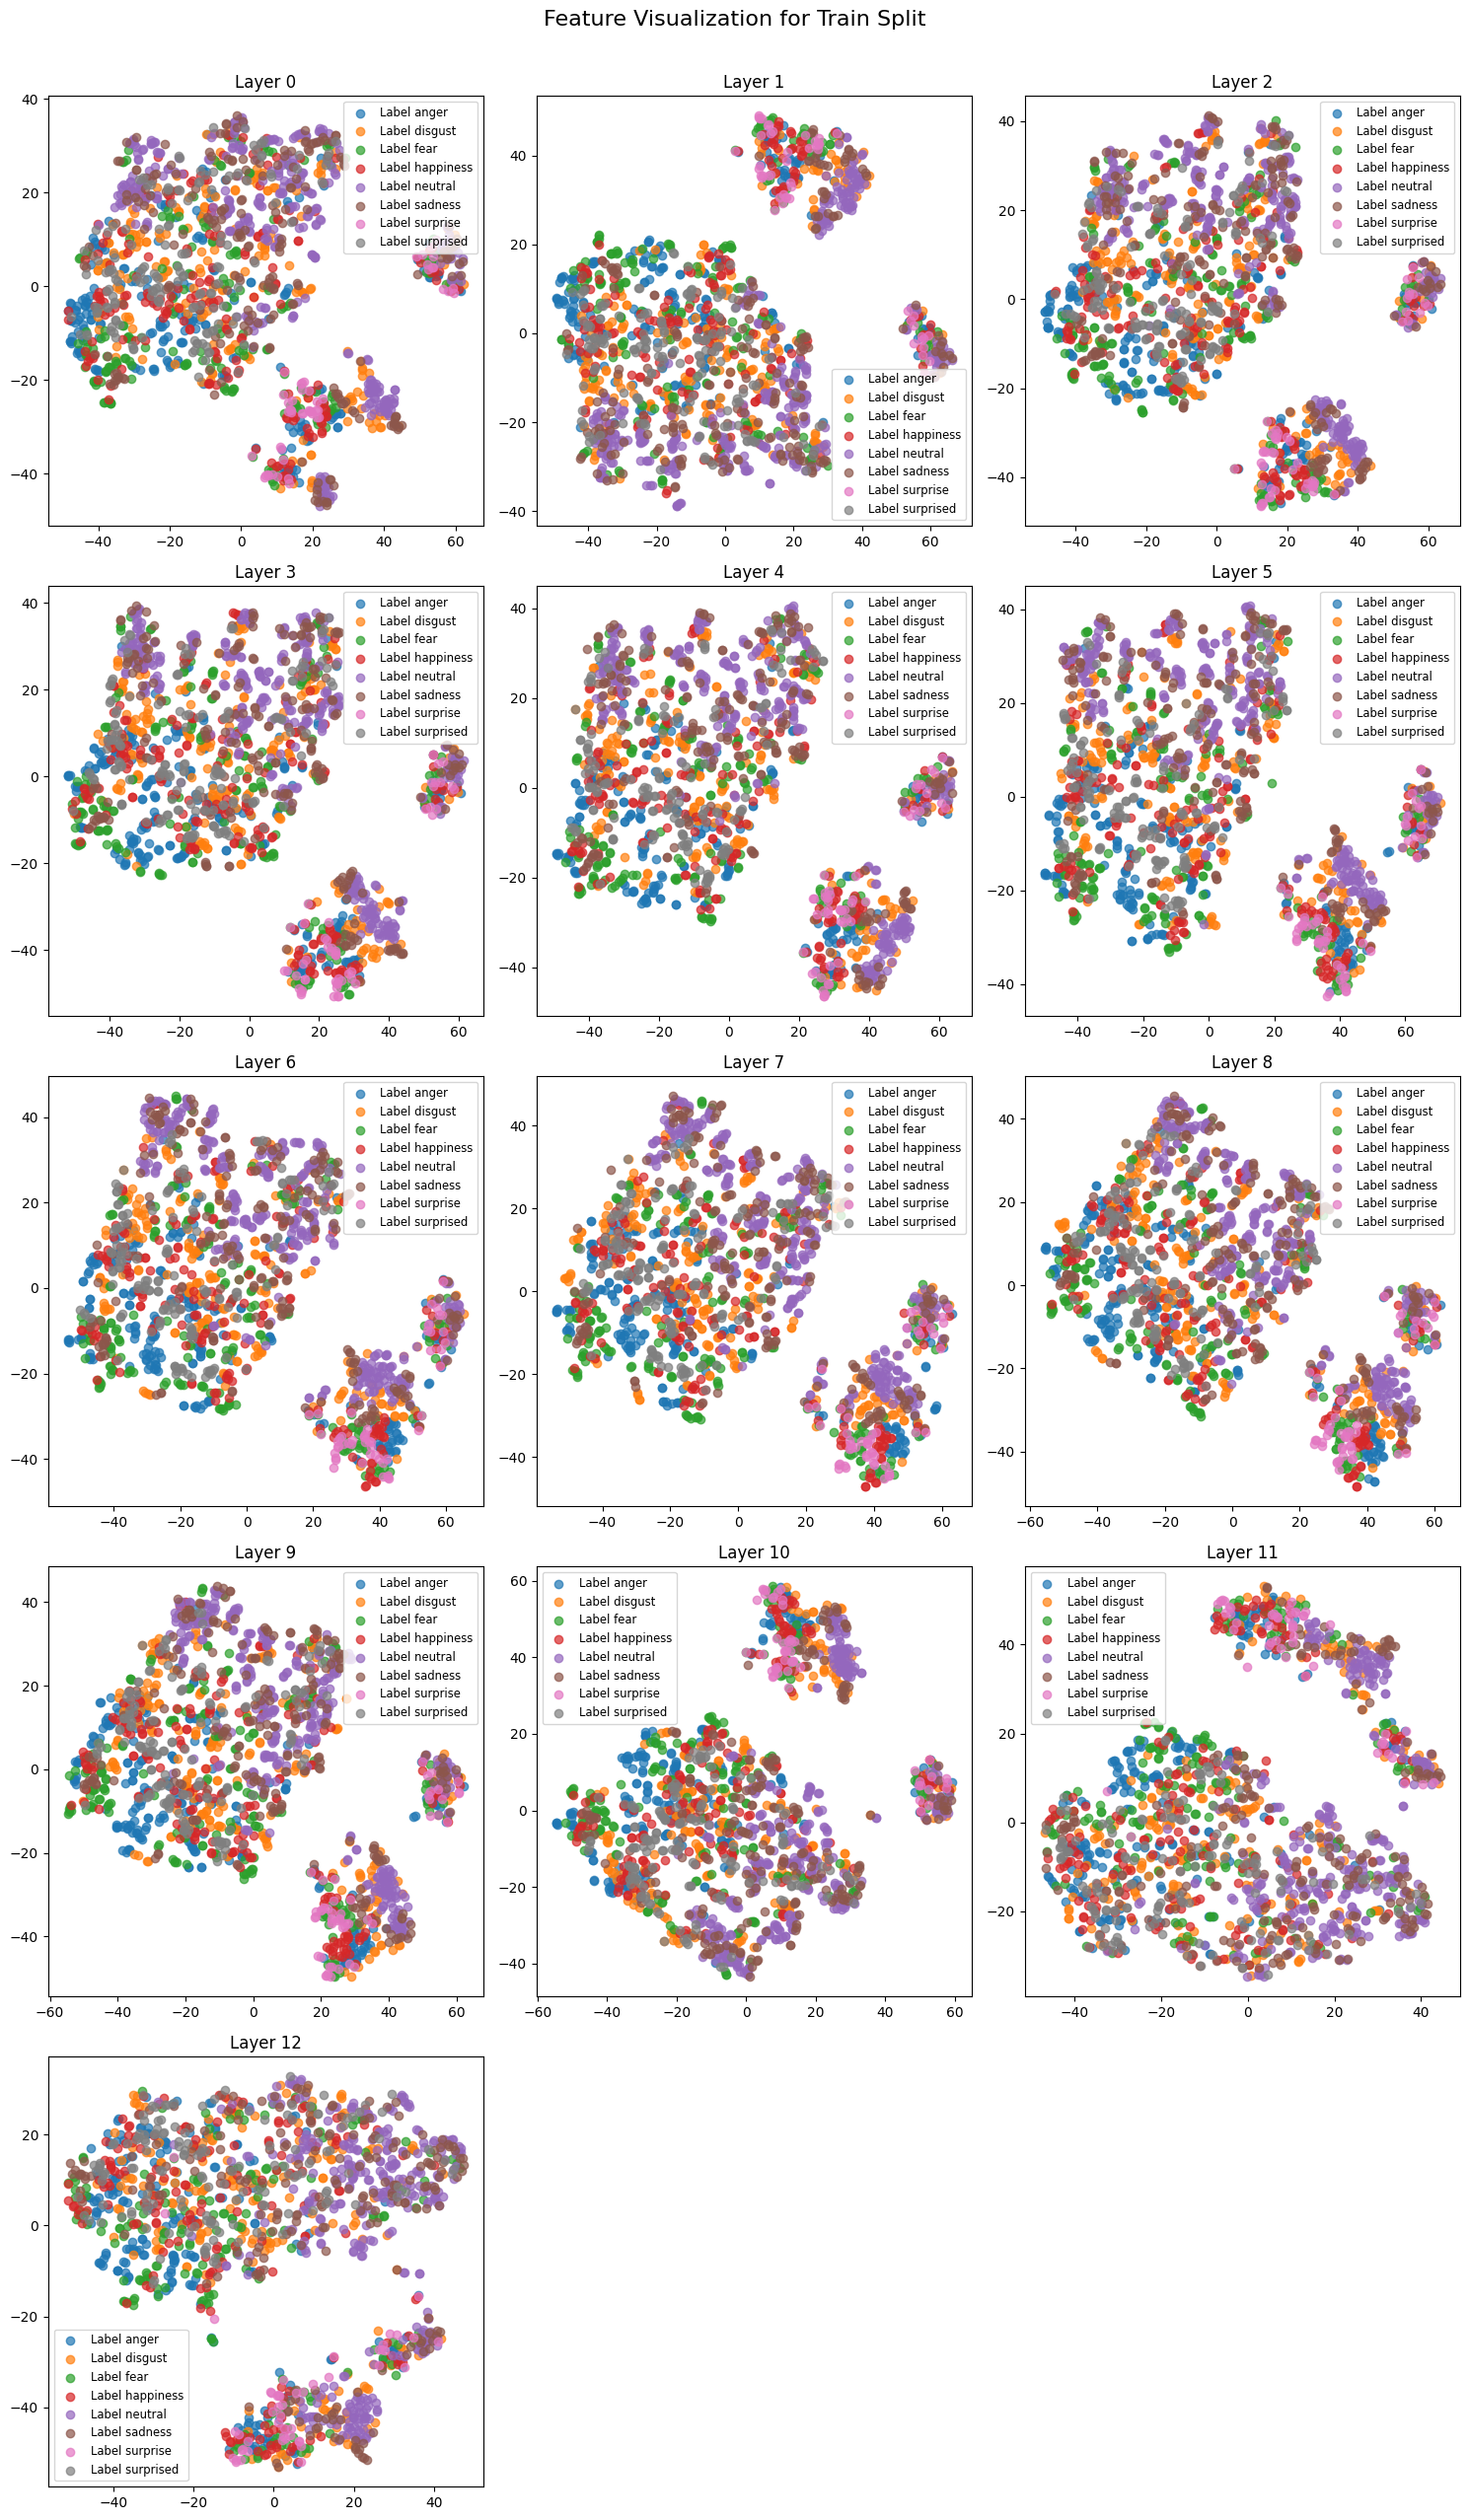

Visualizing validation: 13 layers


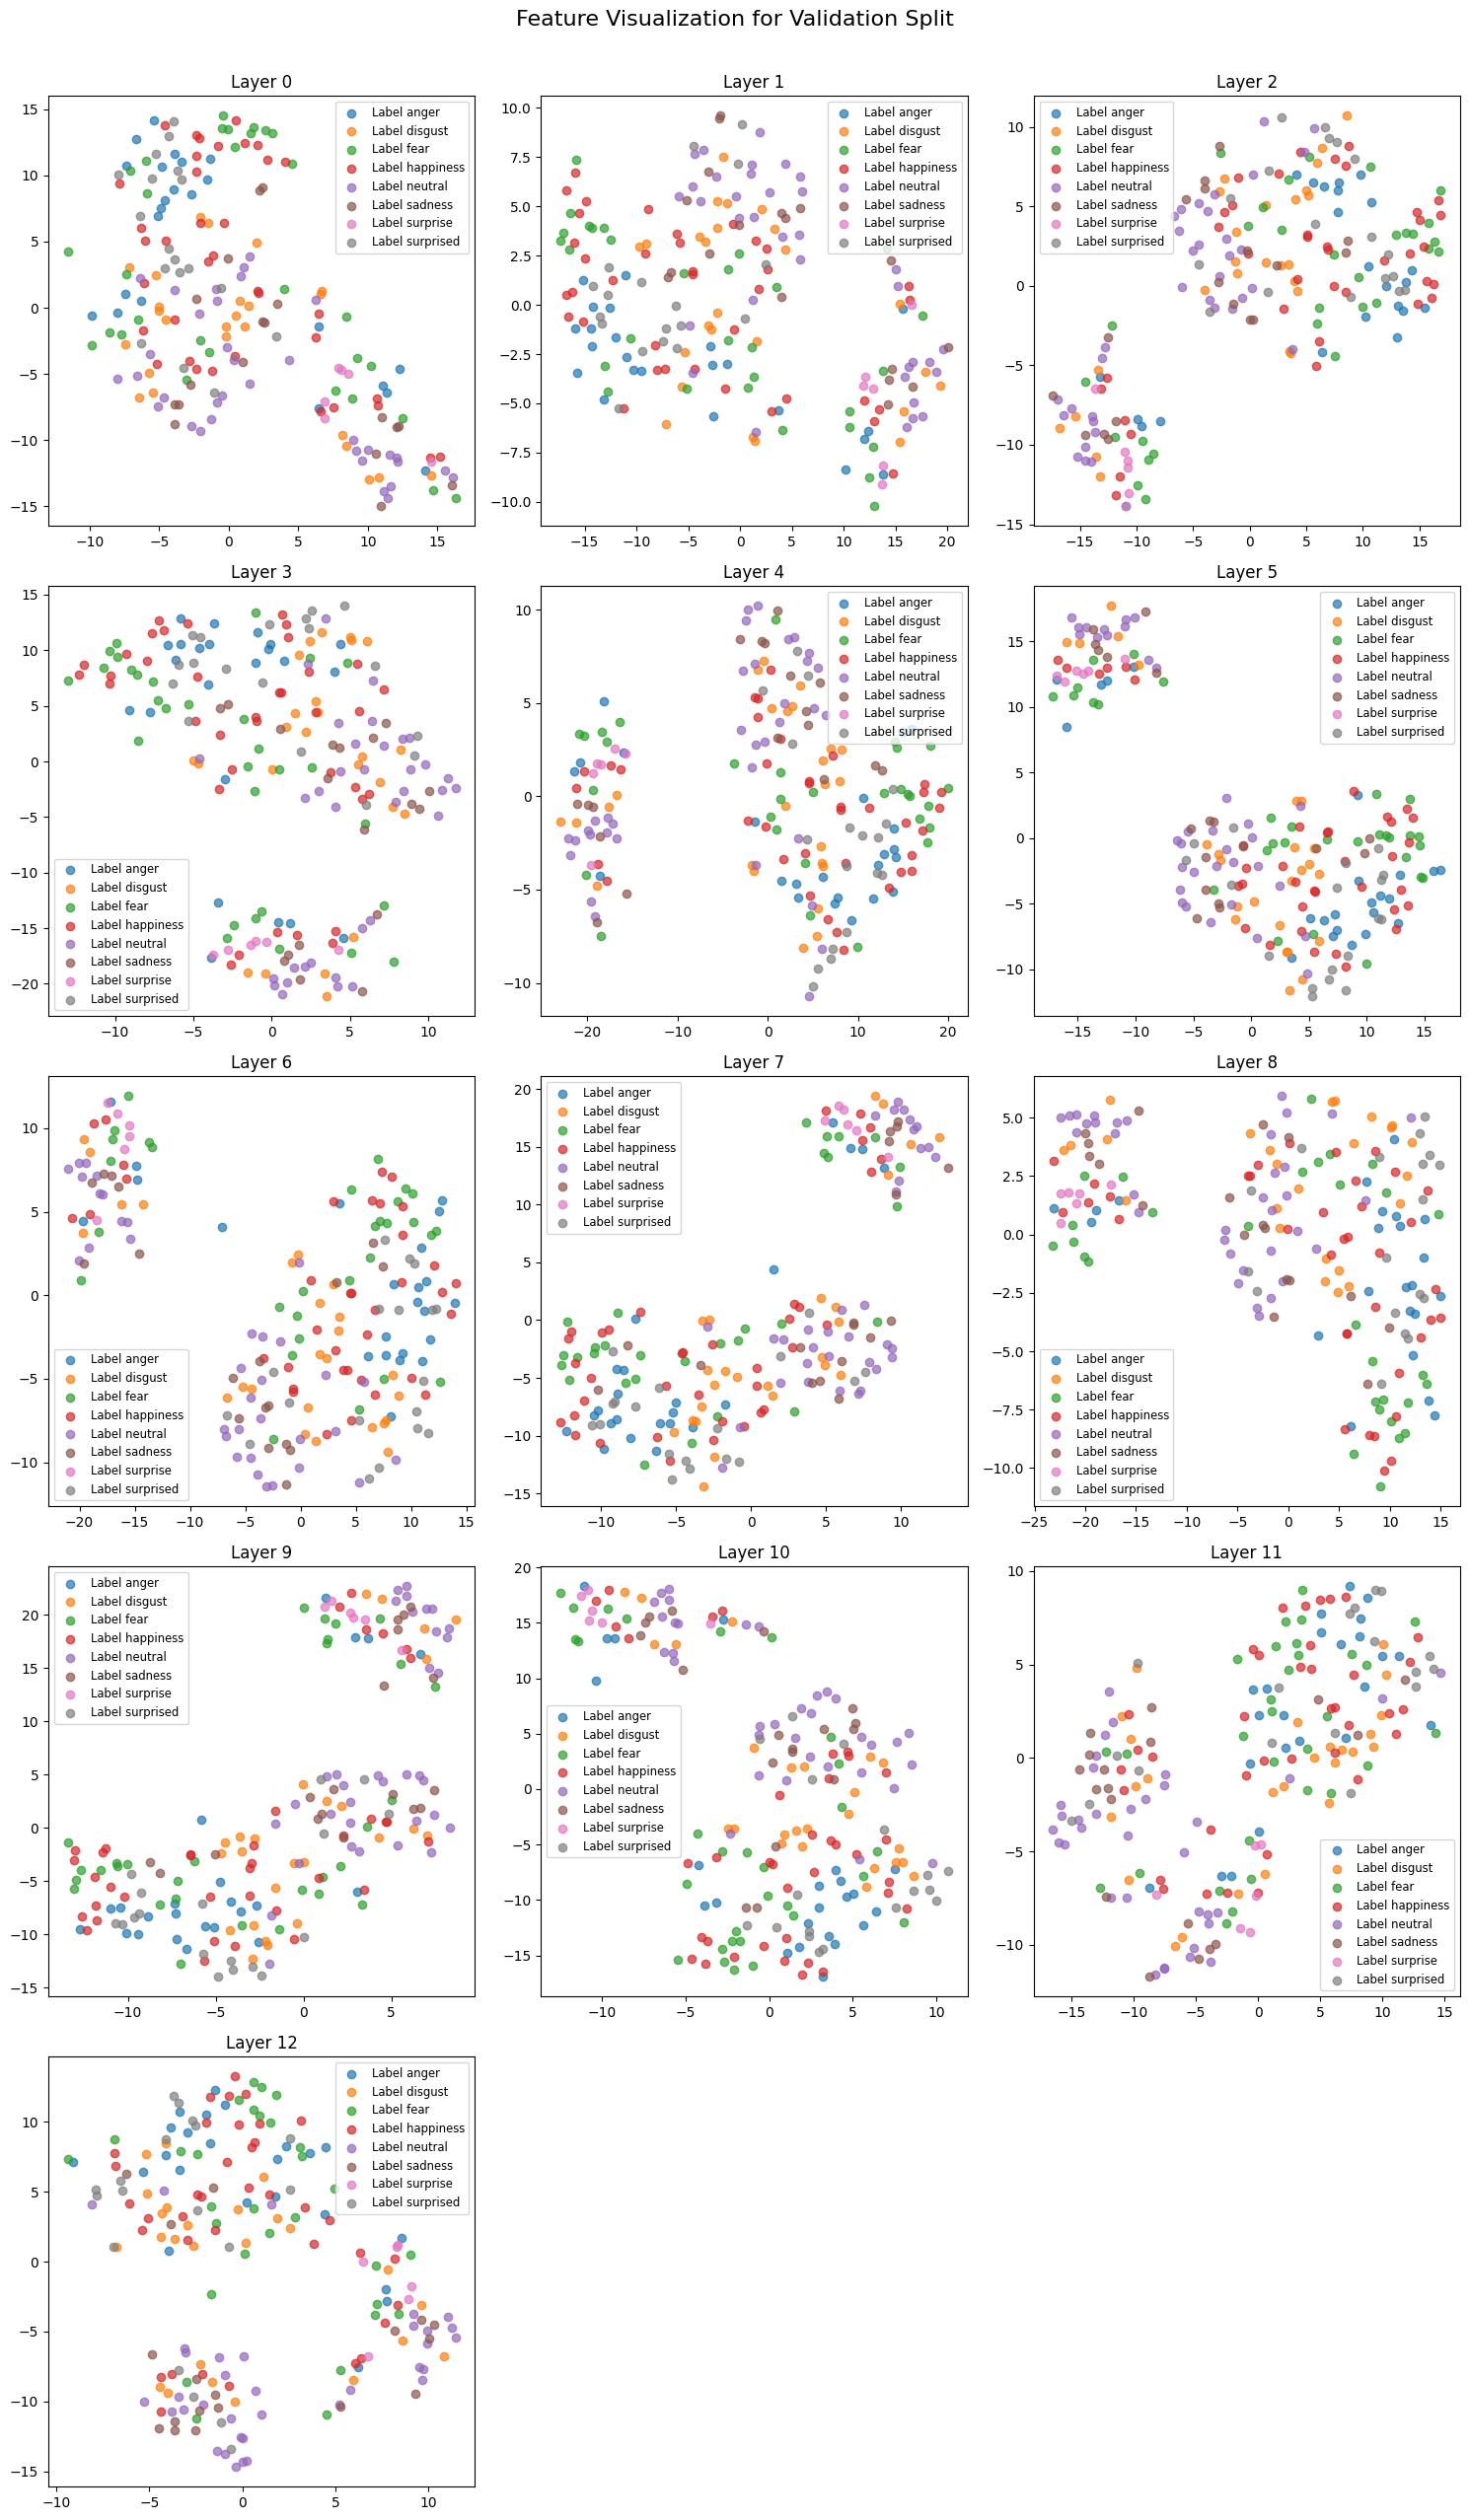

Visualizing test: 13 layers


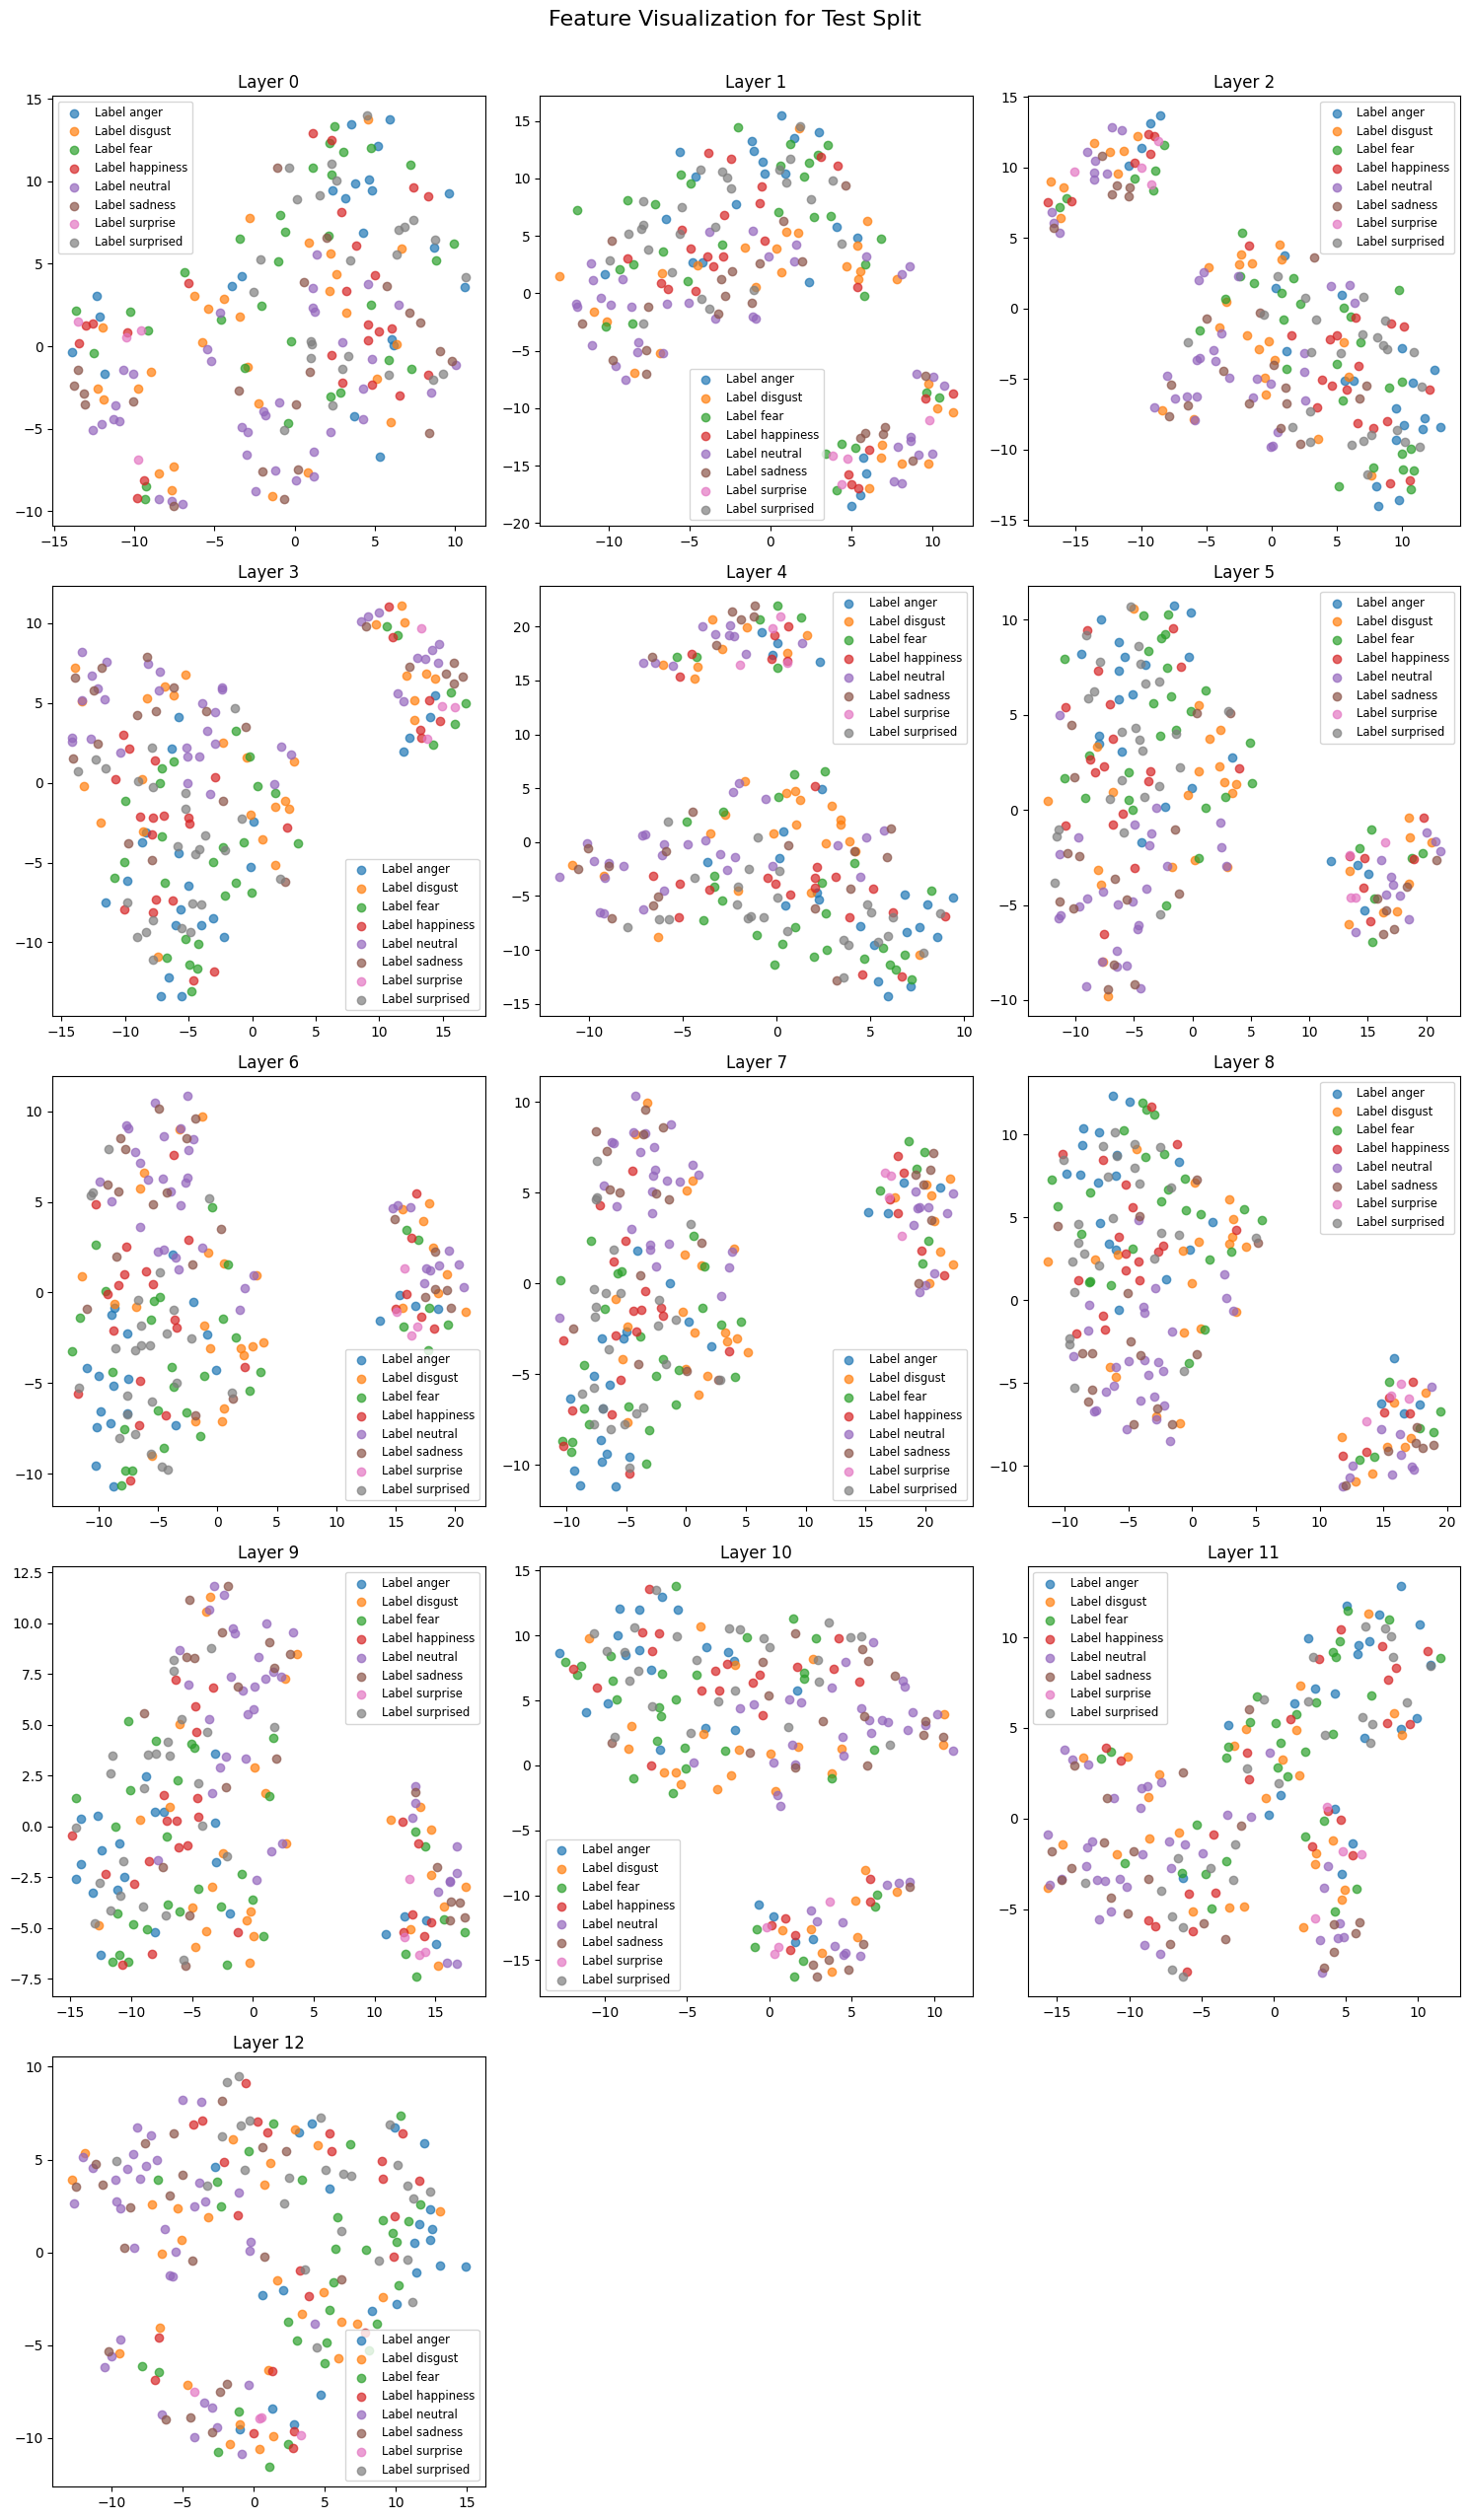

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import os

# Helper function to visualize hidden states for a specific split
def visualize_hidden_states(split_name, output_dir="outputs"):
    # Load hidden states and labels for the split
    hidden_states_path = os.path.join(output_dir, f"{split_name}_hidden_states.npy")
    labels_path = os.path.join(output_dir, f"{split_name}_labels.npy")

    hidden_states = np.load(hidden_states_path)
    labels = np.load(labels_path)
    unique_labels = np.unique(labels)

    # Number of layers
    num_layers = hidden_states.shape[1]
    print(f"Visualizing {split_name}: {num_layers} layers")

    # Create a figure with subplots dynamically for all layers
    fig, axes = plt.subplots((num_layers + 2) // 3, 3, figsize=(15, (num_layers // 3 + 1) * 5))
    axes = axes.flatten()  # Flatten the axes array for easier iteration

    # Visualize each layer
    for layer in range(num_layers):
        X_embedded = TSNE(n_components=2, random_state=42).fit_transform(hidden_states[:, layer, :])
        ax = axes[layer]
        for i, label in enumerate(unique_labels):
            mask = labels == label
            ax.scatter(
                X_embedded[mask, 0],
                X_embedded[mask, 1],
                label=f"Label {label}",
                alpha=0.7
            )
        ax.set_title(f"Layer {layer}")
        ax.legend(loc='best', fontsize='small')

    # Hide unused subplots if num_layers is not a multiple of 3
    for i in range(num_layers, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle(f"Feature Visualization for {split_name.capitalize()} Split", fontsize=16, y=1.02)
    plt.show()


# Visualize train, validation, and test splits
for split in ["train", "validation", "test"]:
    visualize_hidden_states(split_name=split)


### Similarity Tests

similarity metrics code

In [1]:
import torch
from sklearn.metrics.pairwise import linear_kernel
import numpy as np


### TAKEN FROM HERE: https://github.com/minyoungg/platonic-rep/blob/main/metrics.py

## mutual KNN
def compute_nearest_neighbors(feats, topk=1):
    """
    Compute the nearest neighbors of feats
    Args:
        feats: a torch tensor of shape N x D
        topk: the number of nearest neighbors to return
    Returns:
        knn: a torch tensor of shape N x topk
    """
    assert feats.ndim == 2, f"Expected feats to be 2D, got {feats.ndim}"
    knn = (
        (feats @ feats.T).fill_diagonal_(-1e8).argsort(dim=1, descending=True)[:, :topk]
    )
    return knn

def mutual_knn(feats_A, feats_B, topk):
    """
    Computes the mutual KNN accuracy.

    Args:
        feats_A: A torch tensor of shape N x feat_dim
        feats_B: A torch tensor of shape N x feat_dim

    Returns:
        A float representing the mutual KNN accuracy
    """
    knn_A = compute_nearest_neighbors(feats_A, topk)
    knn_B = compute_nearest_neighbors(feats_B, topk)

    n = knn_A.shape[0]
    topk = knn_A.shape[1]

    # Create a range tensor for indexing
    range_tensor = torch.arange(n, device=knn_A.device).unsqueeze(1)

    # Create binary masks for knn_A and knn_B
    lvm_mask = torch.zeros(n, n, device=knn_A.device)
    llm_mask = torch.zeros(n, n, device=knn_A.device)

    lvm_mask[range_tensor, knn_A] = 1.0
    llm_mask[range_tensor, knn_B] = 1.0

    acc = (lvm_mask * llm_mask).sum(dim=1) / topk

    return acc.mean().item()


## CKA
def hsic_unbiased(K, L):
    """
    Compute the unbiased Hilbert-Schmidt Independence Criterion (HSIC) as per Equation 5 in the paper.
    > Reference: https://jmlr.csail.mit.edu/papers/volume13/song12a/song12a.pdf
    """
    m = K.shape[0]

    # Zero out the diagonal elements of K and L
    K_tilde = K.clone().fill_diagonal_(0)
    L_tilde = L.clone().fill_diagonal_(0)

    # Compute HSIC using the formula in Equation 5
    HSIC_value = (
        (torch.sum(K_tilde * L_tilde.T))
        + (torch.sum(K_tilde) * torch.sum(L_tilde) / ((m - 1) * (m - 2)))
        - (2 * torch.sum(torch.mm(K_tilde, L_tilde)) / (m - 2))
    )

    HSIC_value /= m * (m - 3)
    return HSIC_value


def hsic_biased(K, L):
    """ Compute the biased HSIC (the original CKA) """
    H = torch.eye(K.shape[0], dtype=K.dtype, device=K.device) - 1 / K.shape[0]
    return torch.trace(K @ H @ L @ H)

def cka(feats_A, feats_B, kernel_metric='ip', rbf_sigma=1.0, unbiased=False):
        """Computes the unbiased Centered Kernel Alignment (CKA) between features."""

        if kernel_metric == 'ip':
            # Compute kernel matrices for the linear case
            K = torch.mm(feats_A, feats_A.T)
            L = torch.mm(feats_B, feats_B.T)
        elif kernel_metric == 'rbf':
            # COMPUTES RBF KERNEL
            K = torch.exp(-torch.cdist(feats_A, feats_A) ** 2 / (2 * rbf_sigma ** 2))
            L = torch.exp(-torch.cdist(feats_B, feats_B) ** 2 / (2 * rbf_sigma ** 2))
        else:
            raise ValueError(f"Invalid kernel metric {kernel_metric}")

        # Compute HSIC values
        hsic_fn = hsic_unbiased if unbiased else hsic_biased
        hsic_kk = hsic_fn(K, K)
        hsic_ll = hsic_fn(L, L)
        hsic_kl = hsic_fn(K, L)

        # Compute CKA
        #print('hsic', hsic_kl)
        cka_value = hsic_kl / (torch.sqrt(hsic_kk * hsic_ll) + 1e-6)
        return cka_value.item()


def cosine_similarity(feats_A, feats_B):
    """
    Compute the cosine similarity between two sets of features.
    Args:
        feats_A: a torch tensor of shape N x D
        feats_B: a torch tensor of shape N x D
    Returns:
        a torch tensor of shape N x N
    """
    assert feats_A.ndim == 2, f"Expected feats_A to be 2D, got {feats_A.ndim}"
    assert feats_B.ndim == 2, f"Expected feats_B to be 2D, got {feats_B.ndim}"
    feats_A = feats_A / torch.norm(feats_A, dim=1, keepdim=True)
    feats_B = feats_B / torch.norm(feats_B, dim=1, keepdim=True)
    return feats_A @ feats_B.T

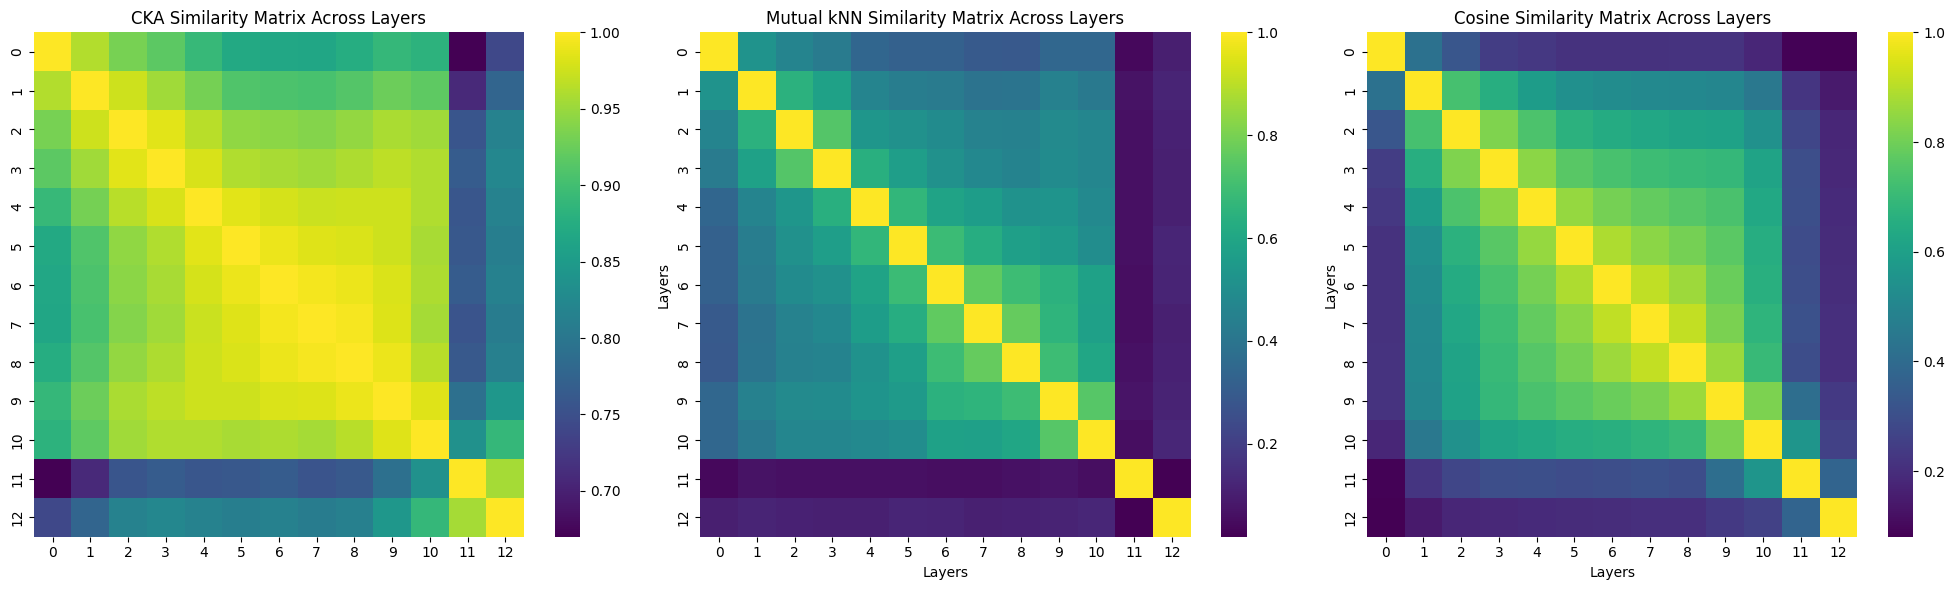

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

hidden_states = np.load("outputs/train_hidden_states.npy")

num_layers = hidden_states.shape[1]
num_samples = hidden_states.shape[0]
hidden_states = torch.tensor(hidden_states)

cka_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        cka_matrix[i, j] = cka(hidden_states[:, i, :], hidden_states[:, j, :])

knn_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        knn_matrix[i, j] = mutual_knn(hidden_states[:, i, :], hidden_states[:, j, :], topk=5)


# Compute cosine similarity
cosine_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        cosine_matrix[i, j] = cosine_similarity(hidden_states[:, i, :], hidden_states[:, j, :]).trace()/num_samples


fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(cka_matrix, ax=axes[0], cmap="viridis")
axes[0].set_title("CKA Similarity Matrix Across Layers")

sns.heatmap(knn_matrix, ax=axes[1], cmap="viridis")
axes[1].set_title("Mutual kNN Similarity Matrix Across Layers")
axes[1].set_xlabel("Layers")
axes[1].set_ylabel("Layers")

sns.heatmap(cosine_matrix, ax=axes[2], cmap="viridis")
axes[2].set_title("Cosine Similarity Matrix Across Layers")
axes[2].set_xlabel("Layers")
axes[2].set_ylabel("Layers")

plt.tight_layout()
plt.show()

### Convexity Analysis

In [3]:
!pip install pynndescent

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.3 MB/s eta 0:00:00


In [4]:
import os
import glob
import numpy as np
import torch
import pynndescent
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra
from typing import Dict, List, Tuple
import itertools
import random

#fix random seed
random.seed(42)

def nn(features, num_neig):
    m,n = features.shape
    dis = np.zeros((m,m))
    index = pynndescent.NNDescent(features, n_neighbors=num_neig+1, metric='euclidean', n_jobs=-1)
    ind = index.neighbor_graph[0]
    distances = index.neighbor_graph[1]
    for i in range(m):
        dis[i,ind[i]] = distances[i]
    dis_sym = np.maximum(dis, dis.T)
    return dis_sym

def get_path(Pr: np.ndarray, i: int, j: int) -> List[int]:
    """
    Get the shortest path from i to j.
    Source: https://stackoverflow.com/a/5307890
    """
    path = [j]
    k = j
    while Pr[i, k] != -9999:
        path.append(Pr[i, k])
        k = Pr[i, k]
    return path[::-1]

def get_concept_idx(labels,
                    ) -> Dict[str, List[int]]:
    """
    Arguments:
        labels          List of all classes
    Returns:
        concepts        Dictionary of ids from columns_names belonging to each concept
    """
    classes = np.unique(labels)

    class_dic = {}
    for idx, name in enumerate(labels):
        for key in classes:
            if name == key:
                if key in class_dic.keys():
                    class_dic[key].append(idx)
                else:
                    class_dic[key] = [idx]
    return class_dic


def is_path_in_concept(shortest_path, indices):
    """
    Compute the proportion of the path that is within the concept.
    Arguments:
        shortest_path:  list of all vertices on the path
        indices:        list of all vertices belonging to the concept
    Returns:
        prop:           the proportion of the path that is inside the concept
    """

    if len(shortest_path) <= 2:
        prop = 1
    else:
        length = 0
        outside = 0
        for idx in shortest_path[1:-1]:
            length += 1
            if idx not in indices:
                outside += 1
        prop = (length - outside)/length
    return prop

def compute_paths(dist_matrix, concept, indices, predecessors):
    """
    dist_matrix     output from djikstra
    concept         name of concept
    indices         indeces of all points beloning to concept
    predecessores   output from dijkstra
    """
    proportion = []
    path_exists = []
    all_paths = list(itertools.permutations(indices, r=2))
    n_paths_max = min(len(all_paths), 5000)
    sampled_indices = np.random.choice(list(range(len(all_paths))), n_paths_max, replace=False)
    sampled_paths = [all_paths[index] for index in sampled_indices]
    for id1, id2 in sampled_paths:
        if dist_matrix[id1, id2] == float('inf'):
            exists = False
            proportion.append(0)
        else:
            shortest_path = get_path(predecessors, id1, id2)
            prop = is_path_in_concept(shortest_path, indices)
            proportion.append(prop)
            exists = True
        path_exists.append(exists)
    #print(f"Concept {concept}: "
    #      f"{'{:.2f}'.format(np.mean(proportion) * 100)}% mean proportion of path in concept")
    return proportion, path_exists

def extract_indices(labels: List[str], min_per_class) -> Dict[str, List[int]]:
    class_counts = {}
    for label in labels:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

    indices = []
    for label, count in class_counts.items():
        if count > min_per_class:
            indices.append([i for i, l in enumerate(labels) if l == label])

    return indices

def graph_convexity(features, labels, num_neighbours=10):
    """
    Arguments:
        features:       3D tensor of shape (n_samples, n_layers, n_features)
        labels:         list of all classes
        num_neighbours: number of neighbours to consider in the graph
    Returns:
        proportion_all: list of tuples (mean, std) of the proportion of the path that is within the concept averaged across classes
        proportion_class_all: dictionary of dictionaries with the proportion of the path that is within the concept
    """
    proportion_all = []
    proportion_class_all = {}
    num_layers = features.shape[1]
    for lay in range(num_layers):
        print(f"Start Layer {lay}")
        prop = []
        proportion_class = {}
        dis_sym = nn(features[:,lay,:], num_neighbours)
        graph = csr_matrix(dis_sym)
        concept_indices = get_concept_idx(labels)
        dist_matrix, predecessors = dijkstra(csgraph=graph, directed=True,
                                                    return_predecessors=True)
        for concept, indices in concept_indices.items():
            proportion, path_exists = compute_paths(dist_matrix,concept,indices,predecessors)
            prop.extend(proportion)
            proportion_class[concept] = (np.mean(proportion), np.std(proportion)/ np.sqrt(len(indices)))
        proportion_all.append((np.mean(prop), np.std(prop)/ np.sqrt(len(indices))))
        proportion_class_all[f'Layer {lay}'] = proportion_class
        print(f"Layer {lay}: ", proportion_all[-1])

    return proportion_all, proportion_class_all

Start Layer 0
Layer 0:  (0.3550615953546528, 0.024608610565191064)
Start Layer 1
Layer 1:  (0.34592693406578584, 0.02434520789195322)
Start Layer 2
Layer 2:  (0.3481592441085098, 0.024679675952641016)
Start Layer 3
Layer 3:  (0.3572698467531578, 0.024777373479176867)
Start Layer 4
Layer 4:  (0.371253903343356, 0.025343096838045802)
Start Layer 5
Layer 5:  (0.41021141416067985, 0.0260599124722313)
Start Layer 6
Layer 6:  (0.4206271960497594, 0.026106768267434546)
Start Layer 7
Layer 7:  (0.4275217114883336, 0.026823934793459226)
Start Layer 8
Layer 8:  (0.4202079280310254, 0.02694065879910134)
Start Layer 9
Layer 9:  (0.39670685782101, 0.02552138571322792)
Start Layer 10
Layer 10:  (0.4072848665946129, 0.0258495182448168)
Start Layer 11
Layer 11:  (0.3223311418591792, 0.023235995226361775)
Start Layer 12
Layer 12:  (0.321593193040456, 0.02358727216766789)


Text(0.5, 1.0, 'Convexity of Words Across Layers')

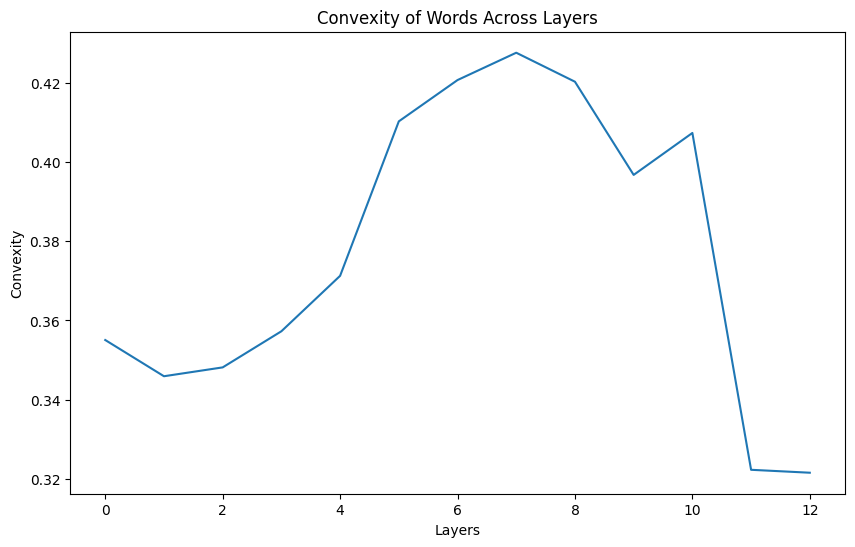

In [5]:
hidden_states = np.load("outputs/train_hidden_states.npy")
labels = np.load("outputs/train_labels.npy")

# Compute convexity, this can take some time depending on the size of the dataset
convexity,_ = graph_convexity(hidden_states, labels, num_neighbours=10)

plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in convexity])
plt.xlabel("Layers")
plt.ylabel("Convexity")
plt.title("Convexity of Words Across Layers")

### Model Fine-Tuning

prepare dataset for fine tuning

In [4]:
from transformers import Wav2Vec2ForSequenceClassification
from torch.optim import AdamW

num_labels = len(set(dataset["train"]["emotion"]))
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=num_labels,
    problem_type="single_label_classification"
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)




Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Data Loader Class


In [7]:
from torch.utils.data import DataLoader

emotion_mapping = {
    "neutral": 0,
    "happiness": 1,
    "sadness": 2,
    "anger": 3,
    "fear": 4,
    "disgust": 5,
    "surprise": 6
}


# Define a PyTorch Dataset class
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, processor, max_length=16000):
        self.dataset = dataset
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        input_values = self.processor(
            sample["audio"]["array"],
            sampling_rate=16000,
            padding=True,
            truncation=True,
            max_length = self.max_length,
            return_tensors="pt"
        ).input_values[0]  # Extract input values
        label = emotion_mapping[sample["emotion"]]
        label = torch.tensor(label, dtype=torch.long)
        return {"input_values": input_values, "labels": label}

# Create DataLoader instances
train_dataset = EmotionDataset(dataset["train"], processor)
validation_dataset = EmotionDataset(dataset["validation"], processor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32)


Training Loop

In [8]:
from torch.nn.functional import cross_entropy
from tqdm import tqdm

# Training and validation loop
def train_model(model, train_loader, validation_loader, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()

        # Training phase
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch in tqdm(train_loader, desc="Training"):
            input_values = batch["input_values"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_values, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            train_loss += loss.item()
            predictions = torch.argmax(logits, dim=-1)
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)

        train_accuracy = train_correct / train_total
        print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation phase
        model.eval()
        validation_loss = 0
        validation_correct = 0
        validation_total = 0

        with torch.no_grad():
            for batch in tqdm(validation_loader, desc="Validation"):
                input_values = batch["input_values"].to(device)
                labels = batch["labels"].to(device)

                # Forward pass
                outputs = model(input_values, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                # Metrics
                validation_loss += loss.item()
                predictions = torch.argmax(logits, dim=-1)
                validation_correct += (predictions == labels).sum().item()
                validation_total += labels.size(0)

        validation_accuracy = validation_correct / validation_total
        print(f"Validation Loss: {validation_loss / len(validation_loader):.4f}, Validation Accuracy: {validation_accuracy:.4f}")

    print("Training complete.")


train_model(model, train_loader, validation_loader, optimizer, num_epochs=10)


Epoch 1/10


Training: 100%|██████████| 48/48 [31:06<00:00, 38.89s/it]


Train Loss: 1.9230, Train Accuracy: 0.2233


Validation: 100%|██████████| 6/6 [00:54<00:00,  9.03s/it]


Validation Loss: 1.9849, Validation Accuracy: 0.1823
Epoch 2/10


Training: 100%|██████████| 48/48 [30:58<00:00, 38.72s/it]


Train Loss: 1.8854, Train Accuracy: 0.2467


Validation: 100%|██████████| 6/6 [00:54<00:00,  9.01s/it]


Validation Loss: 1.9142, Validation Accuracy: 0.2188
Epoch 3/10


Training: 100%|██████████| 48/48 [31:04<00:00, 38.84s/it]


Train Loss: 1.8548, Train Accuracy: 0.2624


Validation: 100%|██████████| 6/6 [00:54<00:00,  9.01s/it]


Validation Loss: 1.9337, Validation Accuracy: 0.2396
Epoch 4/10


Training: 100%|██████████| 48/48 [31:04<00:00, 38.85s/it]


Train Loss: 1.8011, Train Accuracy: 0.2878


Validation: 100%|██████████| 6/6 [00:53<00:00,  8.86s/it]


Validation Loss: 1.7981, Validation Accuracy: 0.2656
Epoch 5/10


Training: 100%|██████████| 48/48 [30:59<00:00, 38.74s/it]


Train Loss: 1.7637, Train Accuracy: 0.2969


Validation: 100%|██████████| 6/6 [00:52<00:00,  8.82s/it]


Validation Loss: 1.7910, Validation Accuracy: 0.2969
Epoch 6/10


Training: 100%|██████████| 48/48 [31:14<00:00, 39.05s/it]


Train Loss: 1.7354, Train Accuracy: 0.3079


Validation: 100%|██████████| 6/6 [00:51<00:00,  8.51s/it]


Validation Loss: 1.7513, Validation Accuracy: 0.2969
Epoch 7/10


Training: 100%|██████████| 48/48 [30:56<00:00, 38.68s/it]


Train Loss: 1.7005, Train Accuracy: 0.3294


Validation: 100%|██████████| 6/6 [00:52<00:00,  8.70s/it]


Validation Loss: 1.7684, Validation Accuracy: 0.3125
Epoch 8/10


Training: 100%|██████████| 48/48 [31:04<00:00, 38.84s/it]


Train Loss: 1.6546, Train Accuracy: 0.3522


Validation: 100%|██████████| 6/6 [00:53<00:00,  8.86s/it]


Validation Loss: 1.7605, Validation Accuracy: 0.3438
Epoch 9/10


Training: 100%|██████████| 48/48 [30:53<00:00, 38.61s/it]


Train Loss: 1.6407, Train Accuracy: 0.3529


Validation: 100%|██████████| 6/6 [00:52<00:00,  8.71s/it]


Validation Loss: 1.7310, Validation Accuracy: 0.3385
Epoch 10/10


Training: 100%|██████████| 48/48 [30:48<00:00, 38.51s/it]


Train Loss: 1.5678, Train Accuracy: 0.3893


Validation: 100%|██████████| 6/6 [00:52<00:00,  8.70s/it]

Validation Loss: 1.7870, Validation Accuracy: 0.3073
Training complete.


In [9]:
# Save model
model.save_pretrained("./wav2vec2-emotion-finetuned")
processor.save_pretrained("./wav2vec2-emotion-finetuned")

print("Model and processor saved successfully.")


Model and processor saved successfully.


In [11]:
test_dataset = EmotionDataset(dataset["test"], processor)  # Use the same class as for train/validation
test_loader = DataLoader(test_dataset, batch_size=32)  # Batch size can be adjusted


from sklearn.metrics import classification_report

def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predictions = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_values = batch["input_values"].to(device)
            labels = batch["labels"].to(device)  # True labels
            logits = model(input_values).logits
            preds = torch.argmax(logits, dim=-1)  # Predicted labels

            # Collect predictions and true labels
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Print classification report
    print("\n")
    print(classification_report(true_labels, predictions, target_names=emotion_mapping.keys()))

# Run evaluation
evaluate_model(model, test_loader)


Evaluating: 100%|██████████| 6/6 [00:57<00:00,  9.60s/it]



              precision    recall  f1-score   support

     neutral       0.42      0.86      0.57        37
   happiness       0.00      0.00      0.00        24
     sadness       0.00      0.00      0.00        21
       anger       0.29      0.09      0.14        22
        fear       0.41      0.48      0.44        31
     disgust       0.17      0.25      0.20        28
    surprise       0.30      0.21      0.24        29

    accuracy                           0.32       192
   macro avg       0.23      0.27      0.23       192
weighted avg       0.25      0.32      0.26       192

